In [106]:
#Initial Imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import seaborn as sns
import hvplot.pandas
import json
import matplotlib.pyplot as plt
import plotly.express as px
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)
import plotly.express as px
import numpy as np
%matplotlib inline

In [107]:
# Function for reading and formating CSV files
csvs= ['./Data/WTI_Oil_Historical.csv','./Data/raw_btc_data.csv','./Data/Gold_Historical.csv','./Data/IYW_US_Tech_ETF.csv','./Data/SPY_Historical.csv',]
def csv_read_format(fname):
    df = pd.read_csv(fname, index_col='Date', infer_datetime_format=True, parse_dates=True)
    return df
csv= [csv_read_format(fname) for fname in csvs]
oil_df = csv_read_format('./Data/WTI_Oil_Historical.csv').rename(columns={'Close': 'Oil'})
gold_df = csv_read_format('./Data/Gold_Historical.csv').rename(columns={'Close': 'Gold'})
iyw_df = csv_read_format('./Data/IYW_US_Tech_ETF.csv').rename(columns={'Close':'IYW'})
spy_df = csv_read_format('./Data/SPY_Historical.csv').rename(columns={'Close':'SPY'})
btc_df = csv_read_format('./Data/raw_btc_data.csv')
# Additional Formating for btc_df
btc_df = btc_df.drop(btc_df.columns[[0, 1, 2, 4, 5, 6, 7, 8, 9]], axis=1)
btc_df.columns = ['BTC']
# Additional Formating for iyw_df
iyw_df = iyw_df.drop(iyw_df.columns[[0, 1, 2, 4, 5]], axis=1)
iyw_df.columns = ['IYW']



In [59]:
# Read Avocado_Historical.csv into dataframe, replace '.' as NaN and drop, change column to float, and set date as index
# Because of the sparse data points the Avocado_Historical.csv doesn't read via the csv_read_format function
avo = pd.read_csv('./Data/Avocado_Historical.csv').replace('.', np.nan).dropna().astype({'WPU01110205': 'float'}).set_index('DATE').rename(columns={'WPU01110205': 'avo'})
# Format date
avo.index = pd.to_datetime(avo.index)
# Avocado historical price data
avo.index = avo.index.date
avo_plot = avo.hvplot(
    width=1000,
    height=500,
    title= 'Avocado Data',
    line_color= 'green',
    hover_line_color='lightgreen'
)
avo_plot

:Curve   [index]   (avo)

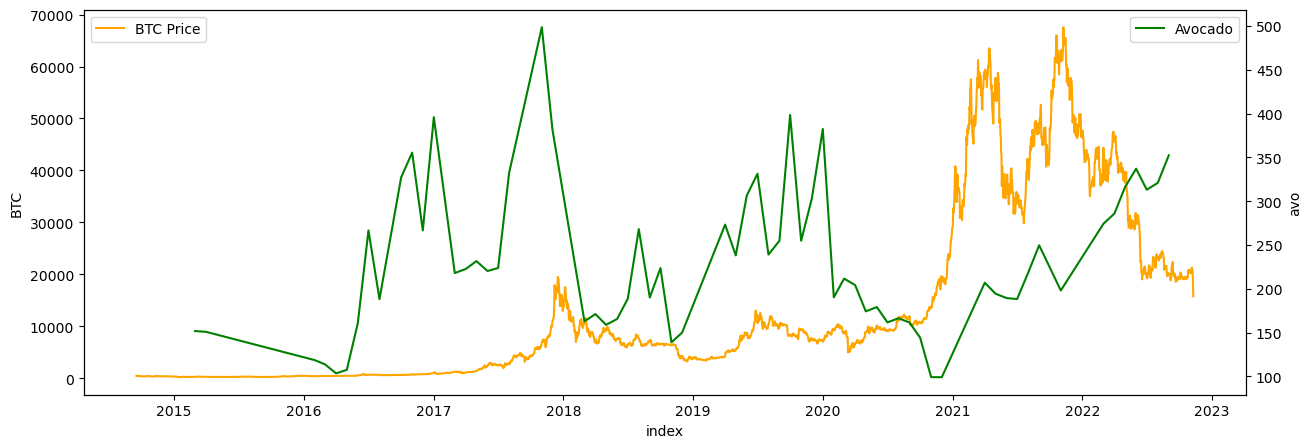

In [60]:
# Plot Avocado data and Btc data together
# Plot function further down doesn't work with the avocado data.
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(btc_df.index, btc_df.BTC, color='orange', label='BTC Price')
ax.set_xlabel('index')
ax.set_ylabel('BTC')
ax2 = ax.twinx()
ax2.plot(avo.index, avo.avo, color='green', label='Avocado')
ax2.set_ylabel('avo')
ax.legend(loc=2)
ax2.legend(loc=0)

In [61]:
# Plot historical BTC pricing with ability to Hover to read pricing on specific dates; for reference purposes
from bokeh.models import HoverTool
hover = HoverTool(tooltips=[("BTC", "@BTC{0,0}"), ("Date", "@Date{%F}")], formatters={'@Date': 'datetime'})
btc_df.hvplot(
    width=1000,
    height=500,
    rot=90,
    yformatter='%.0f',
    title="BTC Historical Pricing"
).opts(tools=[hover])

:Curve   [Date]   (BTC)

In [62]:
# Use .concat to bring all of the various data into one dataframe (except excluding avocado for this analysis)
combined_df = pd.concat([btc_df, iyw_df, gold_df, spy_df, oil_df], axis="columns", join="inner")
combined_df

,BTC,IYW,Gold,SPY,Oil
Date,,,,,
2014-09-17,457.33,25.567499,1225.7,200.75,93.07
2014-09-18,424.44,25.732500,1215.3,201.82,92.41
2014-09-22,402.15,25.402500,1221.0,199.15,91.56
2014-09-23,435.79,25.347500,1218.6,198.01,92.80
2014-09-24,423.20,25.455000,1221.2,199.56,92.53
...,...,...,...,...,...
2022-10-24,19345.57,77.129997,1652.8,378.87,85.32
2022-10-25,20095.86,78.809998,1664.0,384.92,87.91
2022-10-26,20770.44,76.139999,1660.7,382.02,89.08


In [63]:
#Calculate daily returns for each data set ("asset")
combined_returns = combined_df.pct_change()
combined_returns.dropna(inplace=True)
combined_returns

,BTC,IYW,Gold,SPY,Oil
Date,,,,,
2014-09-18,-0.071917,0.006454,-0.008485,0.005330,-0.007091
2014-09-22,-0.052516,-0.012824,0.004690,-0.013230,-0.009198
2014-09-23,0.083650,-0.002165,-0.001966,-0.005724,0.013543
2014-09-24,-0.028890,0.004241,0.002134,0.007828,-0.002909
2014-09-25,-0.027481,-0.023571,-0.005814,-0.016135,0.010915
...,...,...,...,...,...
2022-10-24,0.015316,0.035441,0.001090,0.036835,0.003175
2022-10-25,0.038784,0.021781,0.006776,0.015969,0.030356
2022-10-26,0.033568,-0.033879,-0.001983,-0.007534,0.013309


In [64]:
# Plot daily returns for each asset
combined_returns.hvplot(
    width=1000,
    height=500,
    rot=90,
    yformatter='%.0f',
    title="Combined Historical Returns"
).opts(tools=[hover])

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

<AxesSubplot:title={'center':'Combined Historical Returns'}, xlabel='Date'>

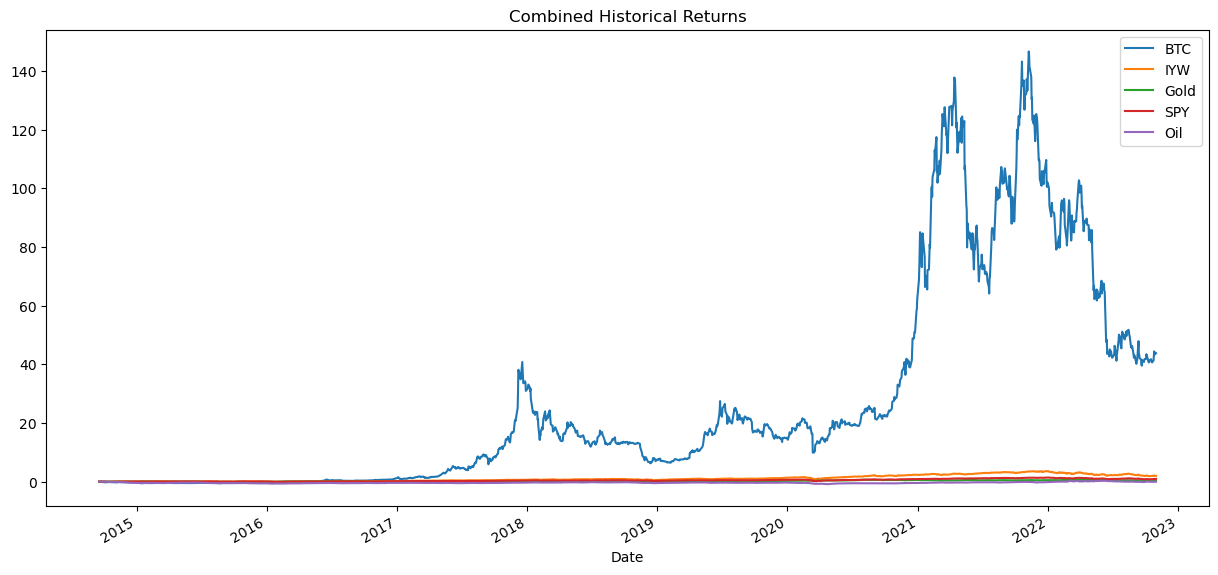

In [65]:
# Calculate cumulative returns of all portfolios
combined_cumu_returns = (1 + combined_returns).cumprod() - 1
combined_cumu_returns

# Plot cumulative returns
combined_cumu_returns.plot(figsize=(15,7), title = "Combined Historical Returns")

<AxesSubplot:title={'center':'Sept 15th 2014 - June 30th 2015'}, xlabel='Date'>

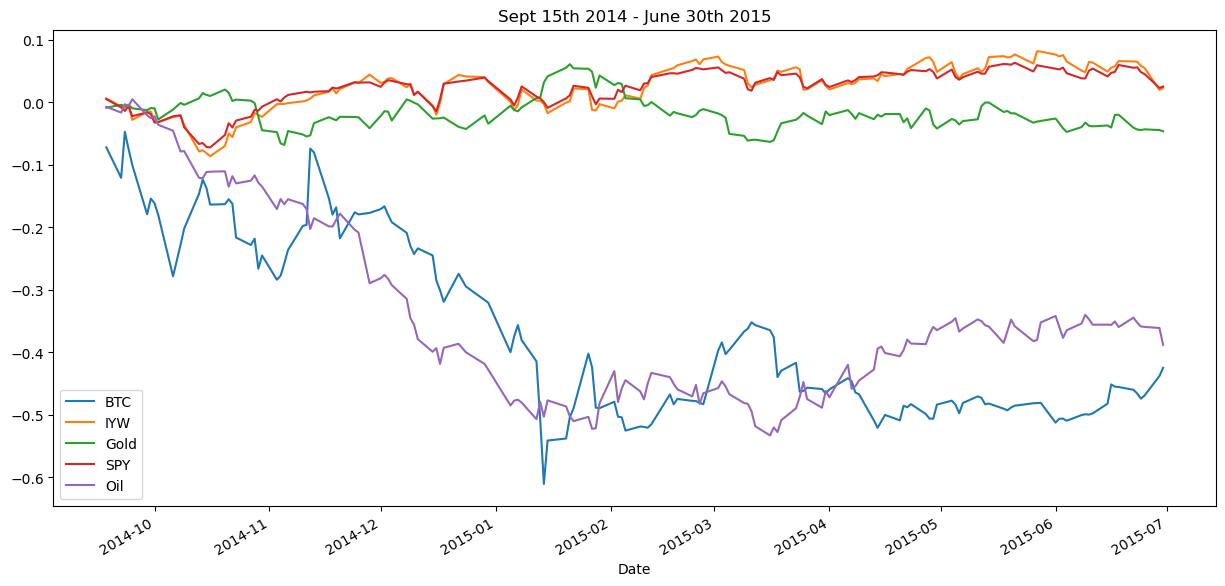

In [105]:
# Calculate cumulative returns of all portfolios during first 9+ months of the available date range
combined_returns_1 = combined_returns.loc['2014-9-15':'2015-06-30']
combined_returns_1

combined_cumu_returns_1 = (1 + combined_returns_1).cumprod() - 1
combined_cumu_returns_1

# Plot cumulative returns
combined_cumu_returns_1.plot(figsize=(15,7), title= 'Sept 15th 2014 - June 30th 2015')

<AxesSubplot:title={'center':'YTD time frame'}, xlabel='Date'>

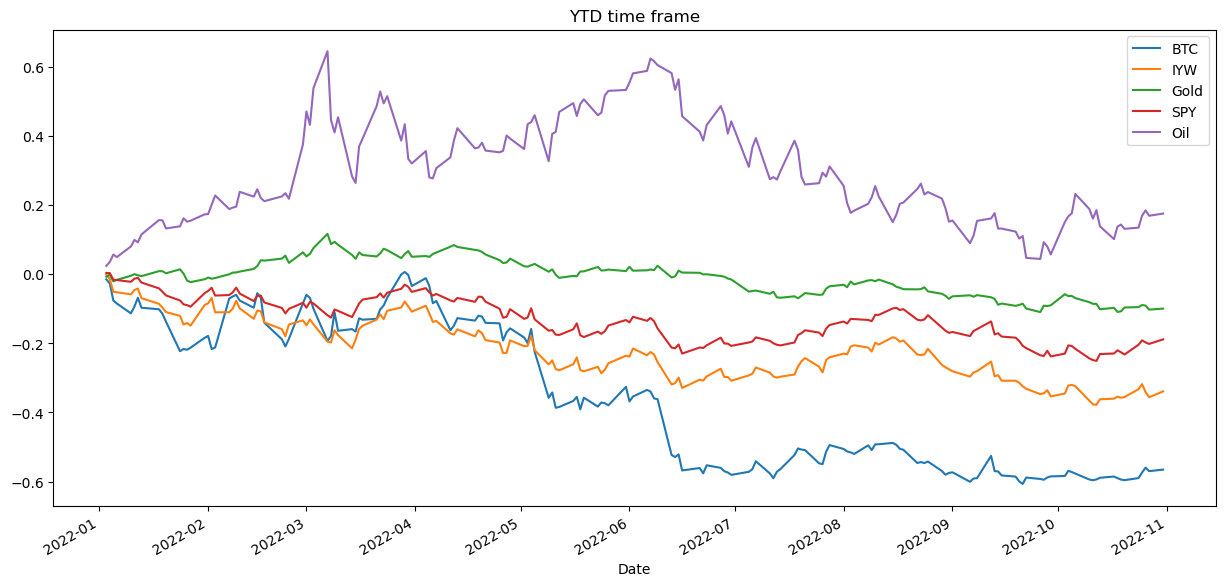

In [104]:
# Calculate cumulative returns of all portfolios in the most recent YTD time period
combined_returns_2 = combined_returns.loc['2022-01-03':'2022-10-31']
combined_returns_2

combined_cumu_returns_2 = (1 + combined_returns_2).cumprod() - 1
combined_cumu_returns_2

# Plot cumulative returns
combined_cumu_returns_2.plot(figsize=(15,7), title= 'YTD time frame')

In [68]:
# Calculate the correlation of cumulative returns for all assets over entire available date range
combined_correlation = combined_cumu_returns.corr()

# Display calculated correlation data
combined_correlation

,BTC,IYW,Gold,SPY,Oil
BTC,1.000000,0.911731,0.768250,0.908296,0.537262
IYW,0.911731,1.000000,0.912357,0.991481,0.529479
Gold,0.768250,0.912357,1.000000,0.881963,0.362547
SPY,0.908296,0.991481,0.881963,1.000000,0.591723
Oil,0.537262,0.529479,0.362547,0.591723,1.000000


<AxesSubplot:>

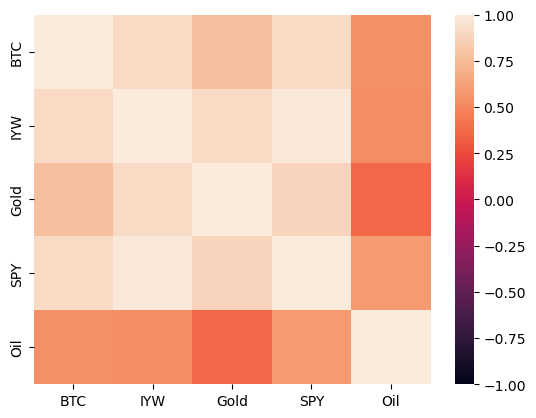

In [69]:
# Use the `heatmap` function from the seaborn library to visualize correlations
sns.heatmap(combined_correlation, vmin=-1, vmax=1)

In [70]:
#For the the Google Pytrends search btc_df needed to be reformated
btc_df2 = csv_read_format('./Data/raw_btc_data.csv')
btc_df2 = btc_df2.drop(btc_df2.columns[[0, 1, 4, 5, 6, 7, 8, 9]], axis=1)
btc_df2.columns = ['BTC_Low','BTC_Close']


In [ ]:
# Build PyTrends payload for 5 years of "Bitcoin" search data
kw_list = ["Bitcoin"]
pytrends.build_payload(kw_list, cat=0, timeframe='2014-09-17 2022-11-09')
# Pull data on from Pytrends on Bitcoin search history
data = pytrends.interest_over_time()
data = data.reset_index()
fig = px.line(data, x="date", y=['Bitcoin'], title='Bitcoin Search Over Time')
fig.show()

In [71]:
# Define a fucntion to tun Pytrends and look at specfic date ranges
searches= [
    '2020-03-09 2020-03-19',
    '2021-02-05 2021-02-15',
    '2021-05-10 2021-05-18',
    '2021-05-17 2021-05-24',
    '2021-12-02 2021-12-14', 
    '2022-06-10 2022-06-19', 
    '2014-09-17 2022-11-09'
    ]
def google_searches(tframe):
    kw_list = ["Bitcoin"]
    pytrends.build_payload(kw_list, cat=0, timeframe=tframe)
    df = pytrends.interest_over_time().drop(columns='isPartial')
    spike_df = pd.concat([df, btc_df2], axis="columns", join="inner").rename(columns={'Bitcoin':'BTC_Searches'})
    return spike_df
spikes = [google_searches(tframe) for tframe in searches]



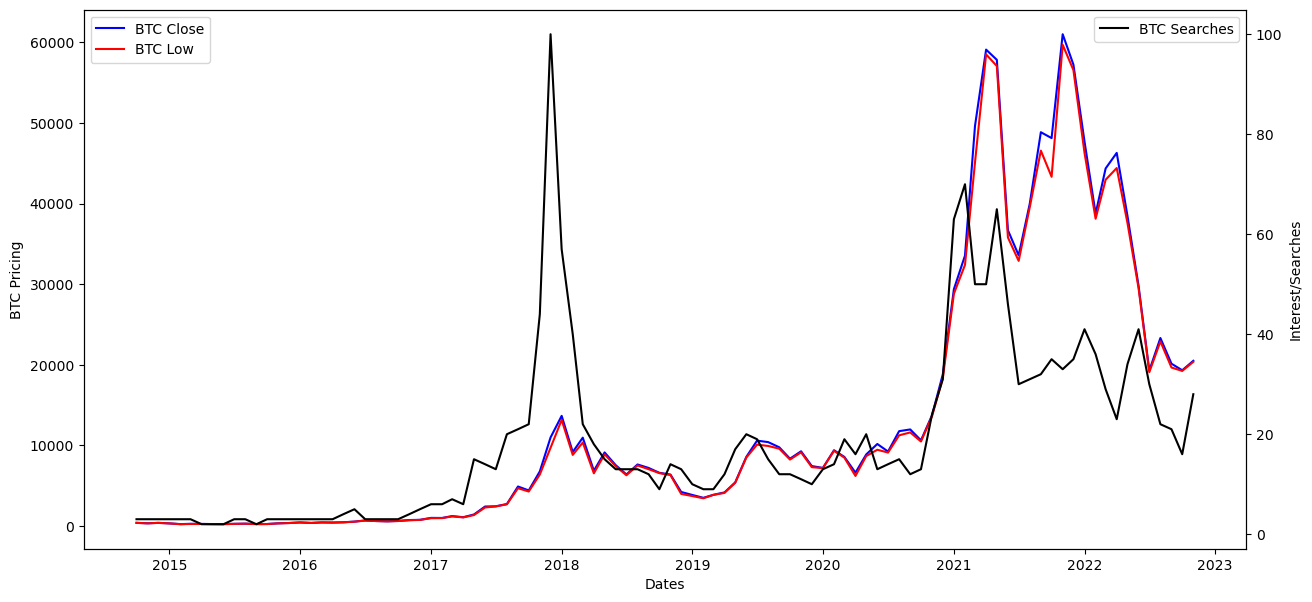

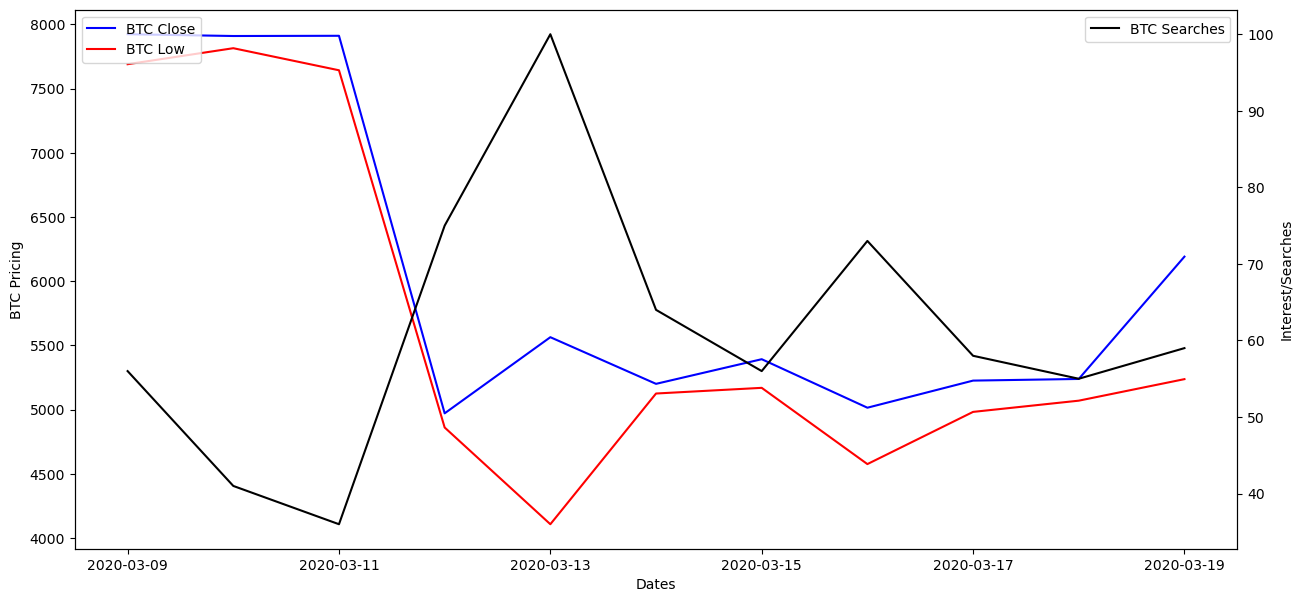

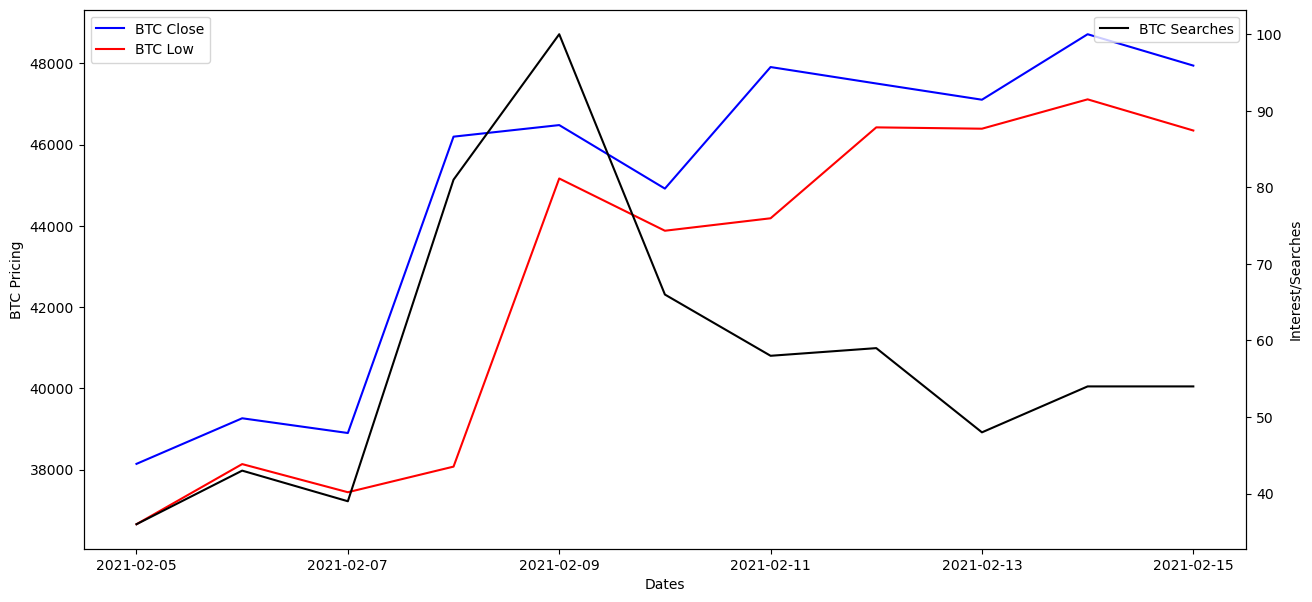

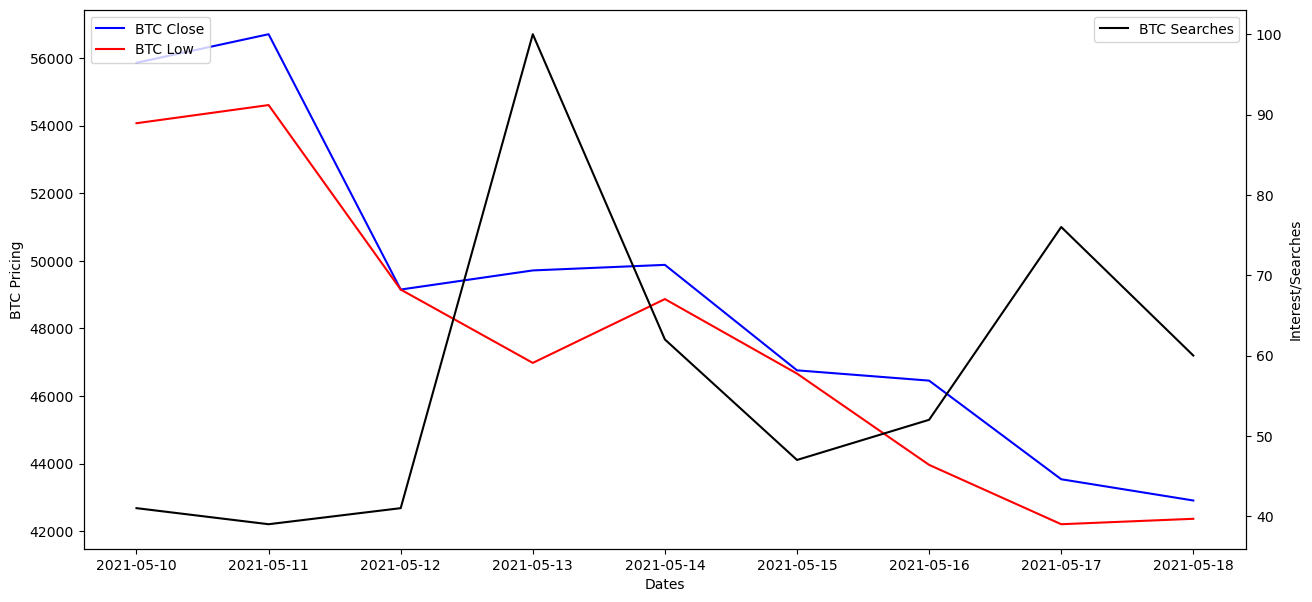

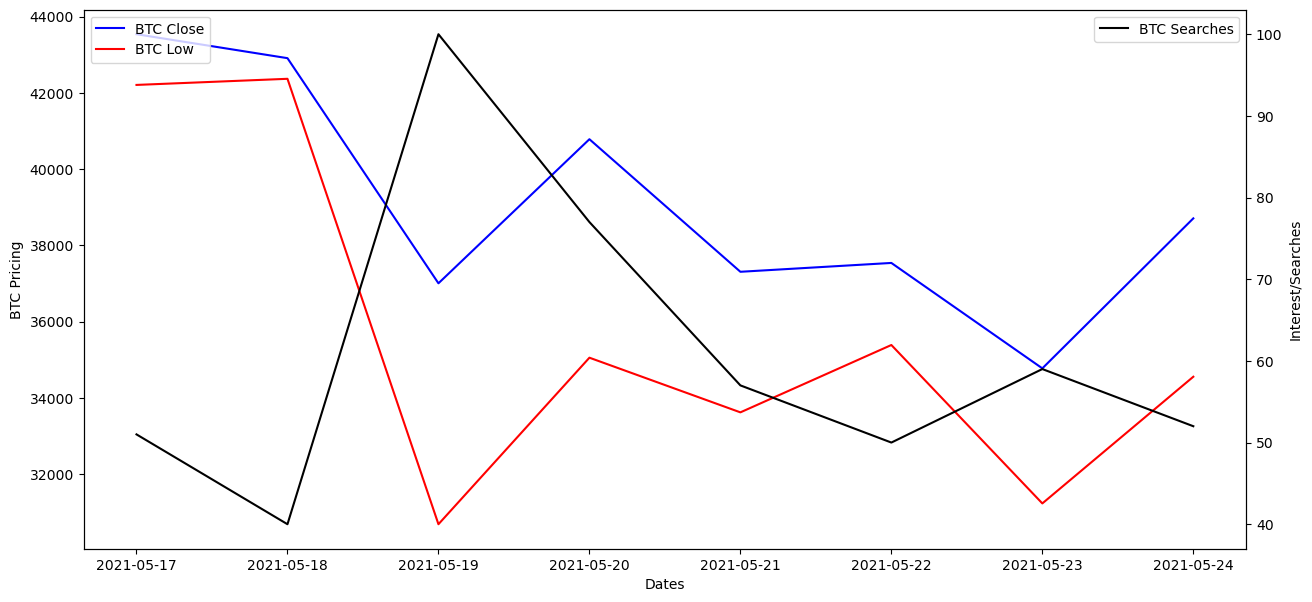

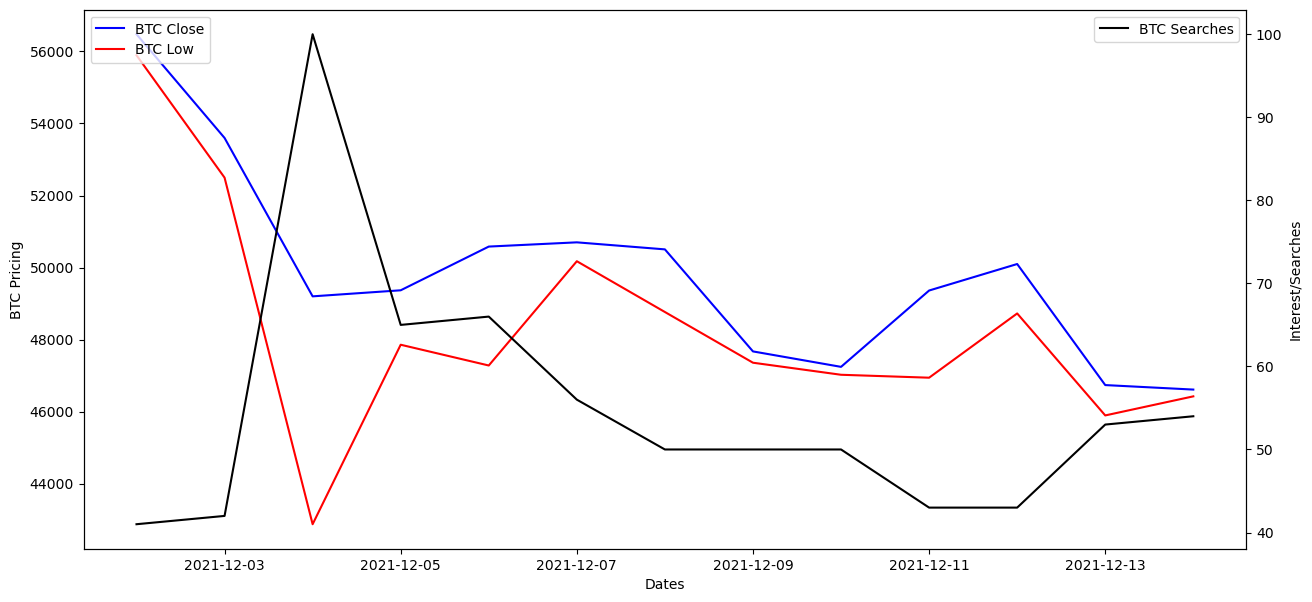

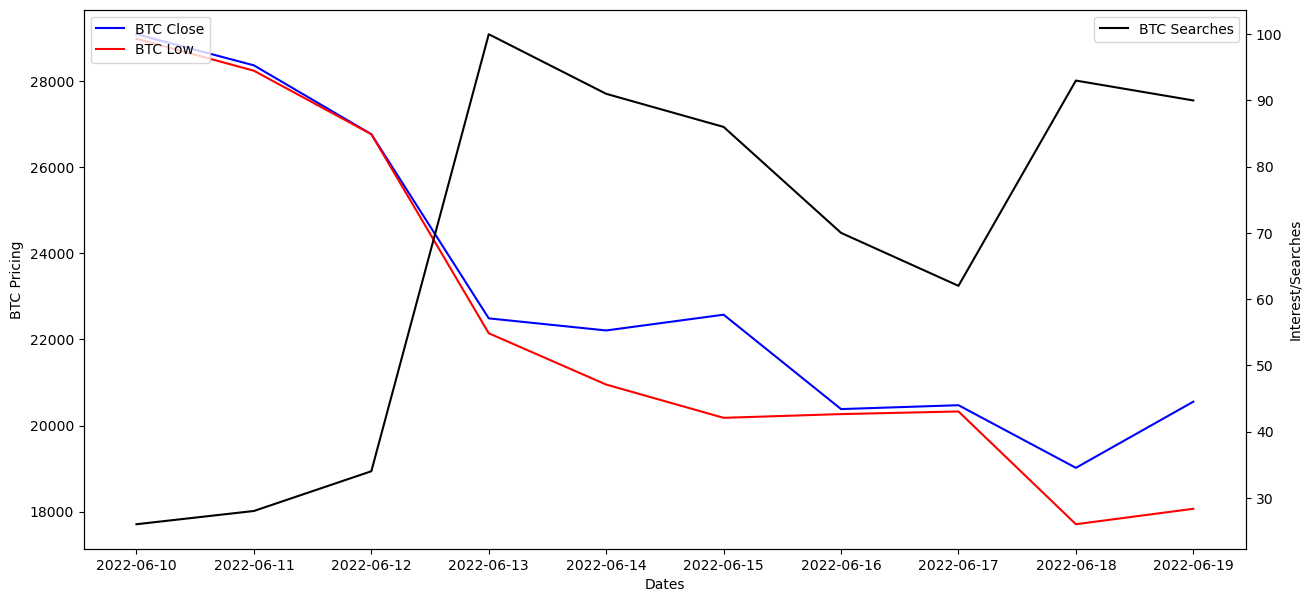

In [103]:
#Define a function to use the Pytrends search data and plot with btc_df2 
spike_searches = [
    google_searches('2014-09-17 2022-11-09'),
    google_searches('2020-03-09 2020-03-19'),
    google_searches('2021-02-05 2021-02-15'),
    google_searches('2021-05-10 2021-05-18'),
    google_searches('2021-05-17 2021-05-24'),
    google_searches('2021-12-02 2021-12-14'),
    google_searches('2022-06-10 2022-06-19')
    ]

def spike_plots(search_time):
    fig,ax = plt.subplots(figsize=(15,7))
    ax.plot(search_time.index, search_time.BTC_Close, color='blue', label='BTC Close')
    ax.plot(search_time.index, search_time.BTC_Low, color='red', label='BTC Low')
    ax.set_xlabel('Dates')
    ax.set_ylabel('BTC Pricing')
    ax2 = ax.twinx()
    ax2.plot(search_time.index, search_time.BTC_Searches, color='black', label='BTC Searches')
    ax2.set_ylabel('Interest/Searches')
    ax.legend(loc=2)
    ax2.legend(loc=0)
    plt.show()
    return plt.show()
search_plot = [spike_plots(search_time) for search_time in spike_searches]
